<a href="https://colab.research.google.com/github/vicente-gonzalez-ruiz/learned_image_compression/blob/main/notebooks/RateDistortionOptimizedAutoencoder_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rate/Distortion Optimized Autoencoder
Based on [Learned data compression](https://www.tensorflow.org/tutorials/generative/data_compression).

In [1]:
LAMBDA = 10000 # We minimize: J = R + lambda*D

In [2]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 4.2 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds
from keras.callbacks import Callback
import numpy as np
import keras
import os
from IPython.display import display, clear_output

In [4]:
training_dataset, validation_dataset = tfds.load(
    "cifar10",
    split=["train[:80%]", "train[80%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)
print(len(training_dataset), len(validation_dataset))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteCD0IQI/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteCD0IQI/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
40000 10000


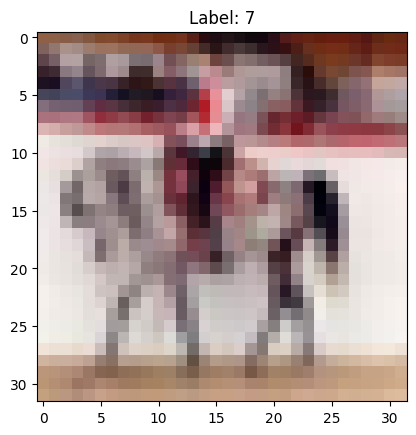

In [5]:
for image, label in training_dataset.take(1):
    # Display the image
    plt.imshow(image)
    plt.title(f"Label: {label.numpy()}")
    plt.show()

In [6]:
PRE_LATENT_SIZE = 2000
LATENT_SIZE = 100
EPOCHS = 10

# Original proposal.
#
# Analysis Transform architecture:
#
#            Ouput
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0  32*32*3      - Input: (height * width * depth)
#      20 16*16*20 conv_1 Conv2D(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 3 input channels of size 32*32, 5*5*3*20 + 20 = 1520 parameters
#      50   8*8*50 conv_2 Conv2D(filters=50, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*50 + 50 = 25050 parameters
#    2000     2000   fc_1 Dense(units=2000), 8*8*50*2000 + 2000 = 3200*2000 + 2000 = 6402000 parameters
#     100      100   fc_2 Dense(units=100), 2000*100 + 100 = 200100 parameters

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

# Synthesis Transform architecture:
#
#           Output
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0      100      - Input: (100)
#    2000     2000   fc_1 Dense(units=2000), 100*2000 + 2000 = 202000 parameters
#    3200     3200   fc_2 Dense(units=3200), 2000*3200 + 3200 = 6403200 parameters, 8*8*50 = 3200
#      20 16*16*20 conv_1 Conv2DTranspose(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 50 input channels of size 8*8, 5*5*50*20 + 20 = 25020 parameters
#       3  32*32*3 conv_2 Conv2DTranspose(filters=3, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*3 + 3 = 1503 parameters

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          3200, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

# Min val_loss: 845.8717 at Epoch 7

In [7]:
PRE_LATENT_SIZE = 2000
LATENT_SIZE = 100
EPOCHS = 10

# Same architecture, but using strides=1.
#
# Analysis Transform architecture:
#
#            Ouput
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0  32*32*3      - Input: (height * width * depth)
#      20 32*32*20 conv_1 Conv2D(filters=20, kernel_size=5, strides=(1, 1), padding="yes"), 3 input channels of size 32*32, 5*5*3*20 + 20 = 1520 parameters
#      50 32*32*50 conv_2 Conv2D(filters=50, kernel_size=5, strides=(1, 1), padding="yes"), 20 input channels of size 32*32, 5*5*20*50 + 50 = 25050 parameters
#    2000     2000   fc_1 Dense(units=2000), 32*32*50*2000 + 2000 = 51200*2000 + 2000 = 102402000 parameters
#     100      100   fc_2 Dense(units=100), 2000*100 + 100 = 200100 parameters

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

# Synthesis Transform architecture:
#
#           Output
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0      100      - Input: (100)
#    2000     2000   fc_1 Dense(units=2000), 100*2000 + 2000 = 202000 parameters
#    3200     3200   fc_2 Dense(units=3200), 2000*51200 + 51200 = 102451200 parameters, 32*32*50 = 51200
#      20 32*32*20 conv_1 Conv2DTranspose(filters=20, kernel_size=5, strides=(1, 1), padding="yes"), 50 input channels of size 32*32, 5*5*50*20 + 20 = 25020 parameters
#       3  32*32*3 conv_2 Conv2DTranspose(filters=3, kernel_size=5, strides=(1, 1), padding="yes"), 20 input channels of size 32*32, 5*5*20*3 + 3 = 1503 parameters

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          51200, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((32, 32, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

# val_loss: 840.7414 at Epoch 10

In [8]:
'''LATENT_SIZE = 8*8*50

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
  ], name="analysis_transform")
  return encoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Reshape((8, 8, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder'''

'LATENT_SIZE = 8*8*50\n\ndef make_analysis_transform(latent_dims=LATENT_SIZE):\n  """Creates the analysis (encoder) transform."""\n  encoder = tf.keras.Sequential([\n      tf.keras.layers.Conv2D(\n          20, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_1"),\n      tf.keras.layers.Conv2D(\n          50, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_2"),\n      tf.keras.layers.Flatten(),\n  ], name="analysis_transform")\n  return encoder\n\ndef make_synthesis_transform():\n  """Creates the synthesis (decoder) transform."""\n  decoder = tf.keras.Sequential([\n      tf.keras.layers.Reshape((8, 8, 50)),\n      tf.keras.layers.Conv2DTranspose(\n          20, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_1"),\n      tf.keras.layers.Conv2DTranspose(\n          3, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_

In [9]:
'''LATENT_SIZE = 32*32*50

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
  ], name="analysis_transform")
  return encoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Reshape((32, 32, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder'''

'LATENT_SIZE = 32*32*50\n\ndef make_analysis_transform(latent_dims=LATENT_SIZE):\n  """Creates the analysis (encoder) transform."""\n  encoder = tf.keras.Sequential([\n      tf.keras.layers.Conv2D(\n          20, 5, use_bias=True, strides=1, padding="same",\n          activation="leaky_relu", name="conv_1"),\n      tf.keras.layers.Conv2D(\n          50, 5, use_bias=True, strides=1, padding="same",\n          activation="leaky_relu", name="conv_2"),\n      tf.keras.layers.Flatten(),\n  ], name="analysis_transform")\n  return encoder\n\ndef make_synthesis_transform():\n  """Creates the synthesis (decoder) transform."""\n  decoder = tf.keras.Sequential([\n      tf.keras.layers.Reshape((32, 32, 50)),\n      tf.keras.layers.Conv2DTranspose(\n          20, 5, use_bias=True, strides=1, padding="same",\n          activation="leaky_relu", name="conv_1"),\n      tf.keras.layers.Conv2DTranspose(\n          3, 5, use_bias=True, strides=1, padding="same",\n          activation="leaky_relu", name="c

In [10]:
'''PRE_LATENT_SIZE = 4096
LATENT_SIZE = 256

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          256*8*8, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 256)),
      tf.keras.layers.Conv2DTranspose(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder'''

'PRE_LATENT_SIZE = 4096\nLATENT_SIZE = 256\n\ndef make_analysis_transform(latent_dims=LATENT_SIZE):\n  """Creates the analysis (encoder) transform."""\n  encoder = tf.keras.Sequential([\n      tf.keras.layers.Conv2D(\n          256, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_1"),\n      tf.keras.layers.Conv2D(\n          256, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_2"),\n      tf.keras.layers.Flatten(),\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),\n      tf.keras.layers.Dense(\n          latent_dims, use_bias=True, activation=None, name="fc_2"),\n  ], name="analysis_transform")\n  return encoder\n\ndef make_synthesis_transform():\n  """Creates the synthesis (decoder) transform."""\n  decoder = tf.keras.Sequential([\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_

In [11]:
'''PRE_LATENT_SIZE = 2000
LATENT_SIZE = 100

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          64, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          128*8*8, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 128)),
      tf.keras.layers.Conv2DTranspose(
          64, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder'''

'PRE_LATENT_SIZE = 2000\nLATENT_SIZE = 100\n\ndef make_analysis_transform(latent_dims=LATENT_SIZE):\n  """Creates the analysis (encoder) transform."""\n  encoder = tf.keras.Sequential([\n      tf.keras.layers.Conv2D(\n          64, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_1"),\n      tf.keras.layers.Conv2D(\n          128, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_2"),\n      tf.keras.layers.Flatten(),\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),\n      tf.keras.layers.Dense(\n          latent_dims, use_bias=True, activation=None, name="fc_2"),\n  ], name="analysis_transform")\n  return encoder\n\ndef make_synthesis_transform():\n  """Creates the synthesis (decoder) transform."""\n  decoder = tf.keras.Sequential([\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1

In [12]:
'''PRE_LATENT_SIZE = 4096
LATENT_SIZE = 256

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Conv2D(
          512, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_3"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          512*4*4, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((4, 4, 512)),
      tf.keras.layers.Conv2DTranspose(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_3"),
  ], name="synthesis_transform")
  return decoder'''

'PRE_LATENT_SIZE = 4096\nLATENT_SIZE = 256\n\ndef make_analysis_transform(latent_dims=LATENT_SIZE):\n  """Creates the analysis (encoder) transform."""\n  encoder = tf.keras.Sequential([\n      tf.keras.layers.Conv2D(\n          128, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_1"),\n      tf.keras.layers.Conv2D(\n          256, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_2"),\n      tf.keras.layers.Conv2D(\n          512, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_3"),\n      tf.keras.layers.Flatten(),\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),\n      tf.keras.layers.Dense(\n          latent_dims, use_bias=True, activation=None, name="fc_2"),\n  ], name="analysis_transform")\n  return encoder\n\ndef make_synthesis_transform():\n  """Creates the synthesis (decoder) transform.""

In [13]:
'''PRE_LATENT_SIZE = 4096
LATENT_SIZE = 256

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          256*8*8, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 256)),
      tf.keras.layers.Conv2DTranspose(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder'''

'PRE_LATENT_SIZE = 4096\nLATENT_SIZE = 256\n\ndef make_analysis_transform(latent_dims=LATENT_SIZE):\n  """Creates the analysis (encoder) transform."""\n  encoder = tf.keras.Sequential([\n      tf.keras.layers.Conv2D(\n          128, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_1"),\n      tf.keras.layers.Conv2D(\n          256, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_2"),\n      tf.keras.layers.Flatten(),\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),\n      tf.keras.layers.Dense(\n          latent_dims, use_bias=True, activation=None, name="fc_2"),\n  ], name="analysis_transform")\n  return encoder\n\ndef make_synthesis_transform():\n  """Creates the synthesis (decoder) transform."""\n  decoder = tf.keras.Sequential([\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_

In [14]:
class CompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor."""

  def __init__(self, latent_dims=LATENT_SIZE):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 32, 32, 3))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per image.
    rate = tf.reduce_mean(rate)

    # Divide rate by the number of neurons in the latent space. This normalizes the rate in bits/neuron.
    rate /= tf.cast(tf.shape(y)[1], dtype=tf.float32)

    # Mean absolute difference across pixels.
    #distortion = tf.reduce_mean(abs(x - x_tilde))
    distortion = tf.sqrt(tf.reduce_mean((x - x_tilde)*(x - x_tilde))) # RMSE
    #distortion = tf.reduce_mean((x - x_tilde)*(x - x_tilde))
    #tf.print(rate, distortion)

    return dict(rate=rate, distortion=distortion)

In [15]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_compression_trainer(lmbda, latent_dims=LATENT_SIZE):
  trainer = CompressionTrainer(latent_dims)
  #custom_metric = MeanMetricWrapper()
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer

In [16]:
class MyCallback(Callback):
    def __init__(self, file_prefix='model_parameters'):
        super(MyCallback, self).__init__()
        self.file_prefix = file_prefix
        self.losses = []

    def on_train_begin(self, logs=None):
        prev_trained_model = os.path.exists("autoencoder_weights.h5")
        if prev_trained_model:
            print(f"Using weights previously generated")
            #self.model = tf.keras.models.load_model("model", custom_objects={'MeanMetricWrapper': MeanMetricWrapper, 'pass_through_loss': pass_through_loss})
            #self.model = keras.models.load_model("model", custom_objects=dict(rate=pass_through_loss, distortion=pass_through_loss))
            x_batch_ = validation_dataset.batch(1).skip(3).take(1)
            # Extract the element from the batch to get a tensor
            x_ = next(iter(x_batch_))
            x_image, _ = x_
            #print(x_)
            _ = self.model(x_image)
            '''
            self.model = make_compression_trainer(LAMBDA)
            self.model.analysis_transform.summary()
            self.model.synthesis_transform.summary()
            self.model.prior_log_scales.summary()
            # Build the model by calling it with dummy input data
            #dummy_input = tf.zeros((1, input_shape))  # Replace input_shape with the actual input shape
            '''
            self.model.analysis_transform.summary()
            self.model.synthesis_transform.summary()
            self.model.load_weights("autoencoder_weights.h5")
        else:
            print("No saved weights found. Training from scratch.")

    def on_epoch_end(self, epoch, logs=None):
        '''
        # Get the model's weights
        model_weights = self.model.get_weights()

        # Save the weights to a file
        file_name = f"{self.file_prefix}_epoch_{epoch + 1}.npy"
        np.save(file_name, model_weights)
        print(f"Saved model parameters at the end of epoch {epoch + 1} to {file_name}")
        '''
        #keras.models.save_model(self.model, "model", custom_objects=dict(rate=pass_through_loss, distortion=pass_through_loss))
        #print("Model saved.")
        self.model.save_weights("autoencoder_weights.h5")
        print("Saved weights.")

        x_batch = validation_dataset.batch(1).skip(3).take(1)
        # Extract the element from the batch to get a tensor
        x = next(iter(x_batch))
        x_image, _ = x
        y = self.model.analysis_transform(x)
        entropy_model = tfc.ContinuousBatchedEntropyModel(self.model.prior, coding_rank=1, compression=False)
        y_tilde, rate = entropy_model(y, training=False)
        x_tilde = self.model.synthesis_transform(y_tilde)[0]

        #clear_output(wait=True)
        plt.subplot(1, 3, 1)
        plt.imshow(x_image.numpy().squeeze().astype(np.uint8))
        plt.subplot(1, 3, 2)
        plt.imshow(x_tilde.numpy().astype(np.uint8))
        if logs is not None and 'val_loss' in logs:
            self.losses.append(logs['val_loss'])
            plt.subplot(1, 3, 3)
            plt.plot(range(1, len(self.losses) + 1), self.losses, marker='o', linestyle='-', color='b')
            plt.title('Validation Loss Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Loss (J)')

        '''
        fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(6, 2))
        axes = axes.ravel()
        x_batch = validation_dataset.batch(1).skip(3).take(1)
        # Extract the element from the batch to get a tensor
        x = next(iter(x_batch))
        x_image, _ = x
        axes[0].imshow(x_image.numpy().squeeze().astype(np.uint8))
        y = self.model.analysis_transform(x)
        entropy_model = tfc.ContinuousBatchedEntropyModel(self.model.prior, coding_rank=1, compression=False)
        y_tilde, rate = entropy_model(y, training=False)
        x_tilde = self.model.synthesis_transform(y_tilde)[0]
        axes[1].imshow(x_tilde.numpy().astype(np.uint8))
        if logs is not None and 'loss' in logs:
            self.losses.append(logs['loss'])
            clear_output(wait=True)
            axes[2].plot(range(1, len(self.losses) + 1), self.losses, marker='o', linestyle='-', color='b')
            #axes[2].title('Training Loss Over Epochs')
            axes[2].xlabel('Epoch')
            axes[2].ylabel('Loss')
        '''

        plt.tight_layout()
        plt.show()

        #y_tilde, rate = self.model.entropy_model(y, training=training)
        '''
        #x_tilde = self.synthesis_transform(y_tilde)

        # Average number of bits per image.
        rate = tf.reduce_mean(rate)

        # Divide rate by the number of neurons in the latent space. This normalizes the rate in bits/neuron.
        rate /= tf.cast(tf.shape(y)[1], dtype=tf.float32)

        # Mean absolute difference across pixels.
        #distortion = tf.reduce_mean(abs(x - x_tilde))
        distortion = tf.sqrt(tf.reduce_mean((x - x_tilde)*(x - x_tilde))) # RMSE
        '''

In [17]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_model(lmbda=LAMBDA, epochs=EPOCHS):
  callbacks_list = [MyCallback()]
  trainer = make_compression_trainer(lmbda)
  trainer.fit(
      training_dataset.map(add_rd_targets).batch(128).prefetch(8),
      epochs=epochs,
      validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
      validation_freq=1,
      verbose=1,
      callbacks=callbacks_list
  )
  return trainer

Using weights previously generated
Model: "analysis_transform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (1, 32, 32, 20)           1520      
                                                                 
 conv_2 (Conv2D)             (1, 32, 32, 50)           25050     
                                                                 
 flatten_1 (Flatten)         (1, 51200)                0         
                                                                 
 fc_1 (Dense)                (1, 2000)                 102402000 
                                                                 
 fc_2 (Dense)                (1, 100)                  200100    
                                                                 
Total params: 102628670 (391.50 MB)
Trainable params: 102628670 (391.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________

313/313 [==============================] - ETA: 0s - loss: 904.2574 - distortion_loss: 0.0900 - rate_loss: 4.0635 - distortion_pass_through_loss: 0.0900 - rate_pass_through_loss: 4.0636

Saved weights.


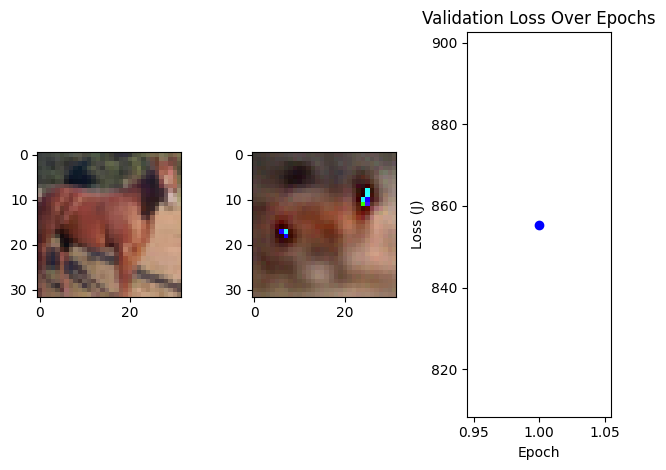

313/313 [==============================] - 43s 129ms/step - loss: 904.2574 - distortion_loss: 0.0900 - rate_loss: 4.0635 - distortion_pass_through_loss: 0.0900 - rate_pass_through_loss: 4.0636 - val_loss: 855.4551 - val_distortion_loss: 0.0851 - val_rate_loss: 4.0256 - val_distortion_pass_through_loss: 0.0852 - val_rate_pass_through_loss: 4.0262
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 822.8008 - distortion_loss: 0.0819 - rate_loss: 4.0070 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 4.0071Saved weights.


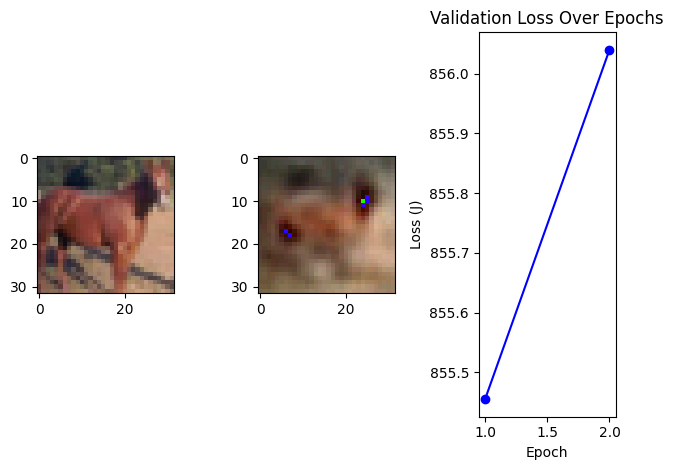

313/313 [==============================] - 39s 126ms/step - loss: 822.8008 - distortion_loss: 0.0819 - rate_loss: 4.0070 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 4.0071 - val_loss: 856.0398 - val_distortion_loss: 0.0852 - val_rate_loss: 4.0041 - val_distortion_pass_through_loss: 0.0852 - val_rate_pass_through_loss: 4.0047
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 815.4061 - distortion_loss: 0.0811 - rate_loss: 4.0056 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 4.0057Saved weights.


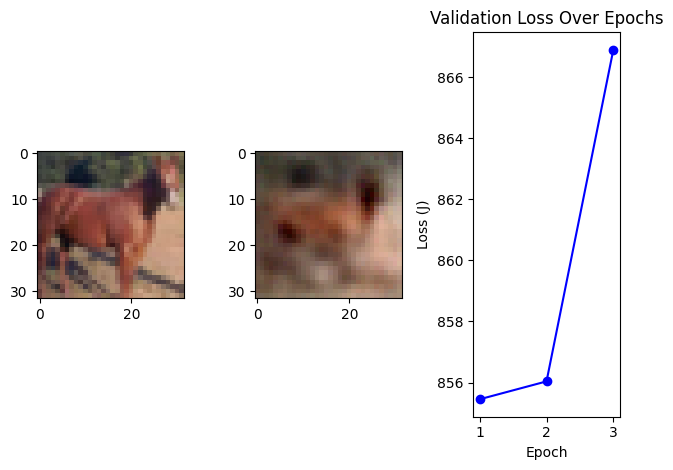

313/313 [==============================] - 38s 121ms/step - loss: 815.4061 - distortion_loss: 0.0811 - rate_loss: 4.0056 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 4.0057 - val_loss: 866.8928 - val_distortion_loss: 0.0863 - val_rate_loss: 3.9713 - val_distortion_pass_through_loss: 0.0863 - val_rate_pass_through_loss: 3.9717
Epoch 4/10
313/313 [==============================] - ETA: 0s - loss: 802.0811 - distortion_loss: 0.0798 - rate_loss: 4.0033 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 4.0034Saved weights.


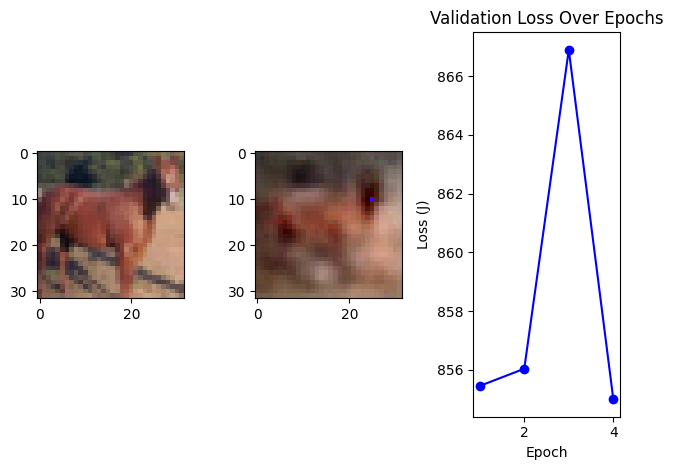

313/313 [==============================] - 38s 120ms/step - loss: 802.0811 - distortion_loss: 0.0798 - rate_loss: 4.0033 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 4.0034 - val_loss: 855.0018 - val_distortion_loss: 0.0851 - val_rate_loss: 3.9838 - val_distortion_pass_through_loss: 0.0851 - val_rate_pass_through_loss: 3.9844
Epoch 5/10
313/313 [==============================] - ETA: 0s - loss: 801.0653 - distortion_loss: 0.0797 - rate_loss: 3.9823 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 3.9824Saved weights.


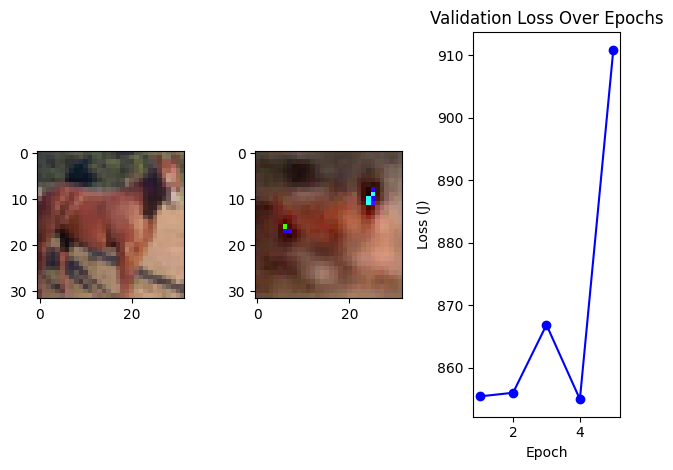

313/313 [==============================] - 45s 144ms/step - loss: 801.0653 - distortion_loss: 0.0797 - rate_loss: 3.9823 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 3.9824 - val_loss: 910.8520 - val_distortion_loss: 0.0907 - val_rate_loss: 3.9349 - val_distortion_pass_through_loss: 0.0907 - val_rate_pass_through_loss: 3.9355
Epoch 6/10
313/313 [==============================] - ETA: 0s - loss: 788.7939 - distortion_loss: 0.0785 - rate_loss: 3.9741 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 3.9743Saved weights.


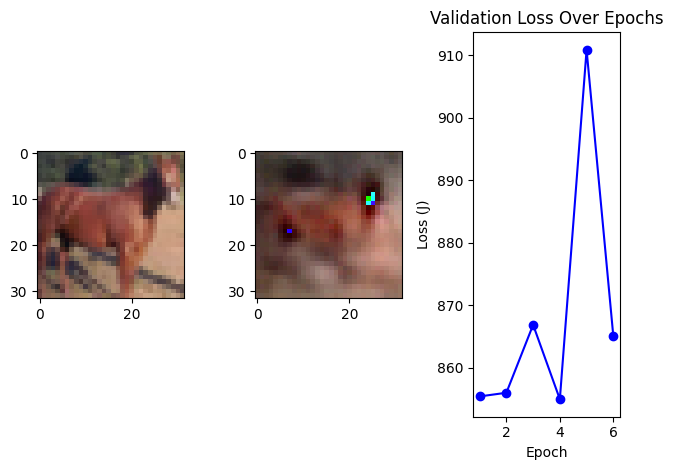

313/313 [==============================] - 38s 123ms/step - loss: 788.7939 - distortion_loss: 0.0785 - rate_loss: 3.9741 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 3.9743 - val_loss: 865.0929 - val_distortion_loss: 0.0861 - val_rate_loss: 3.9440 - val_distortion_pass_through_loss: 0.0861 - val_rate_pass_through_loss: 3.9444
Epoch 7/10
313/313 [==============================] - ETA: 0s - loss: 775.0200 - distortion_loss: 0.0771 - rate_loss: 3.9790 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 3.9791Saved weights.


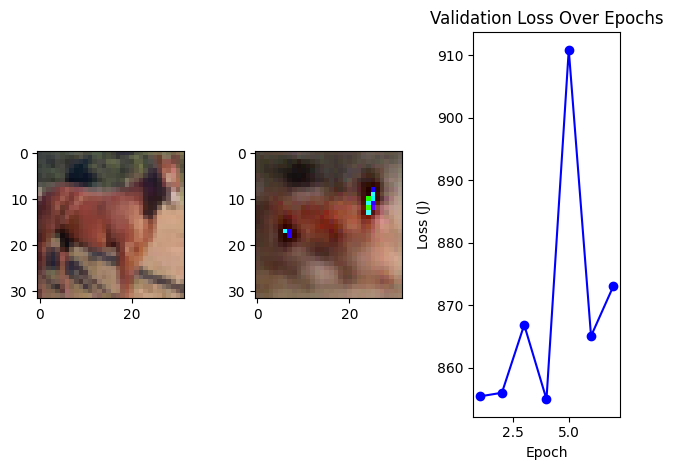

313/313 [==============================] - 46s 147ms/step - loss: 775.0200 - distortion_loss: 0.0771 - rate_loss: 3.9790 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 3.9791 - val_loss: 873.0640 - val_distortion_loss: 0.0869 - val_rate_loss: 3.9384 - val_distortion_pass_through_loss: 0.0869 - val_rate_pass_through_loss: 3.9388
Epoch 8/10
313/313 [==============================] - ETA: 0s - loss: 776.4577 - distortion_loss: 0.0773 - rate_loss: 3.9506 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 3.9506

KeyboardInterrupt: ignored

In [23]:
trainer = train_model(lmbda=LAMBDA)
trainer.analysis_transform.summary()
trainer.synthesis_transform.summary()

In [19]:
class Compressor(tf.keras.Model):
  """Compresses images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits

class Decompressor(tf.keras.Model):
  """Decompresses images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)

def make_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = Compressor(trainer.analysis_transform, entropy_model)
  decompressor = Decompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make_codec(trainer)

In [20]:
def display_images(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.squeeze(originals[i]),
        tf.zeros((32, 32, 3), tf.uint8),
        tf.squeeze(reconstructions[i]),
    ], 1)
    axes[i].imshow(image)
    axes[i].text(
        #.5, .5, f"→ 0x{strings[i].numpy().hex()} →\n{entropies[i]:0.2f} bits",
        .5, .5, f"{entropies[i]:0.2f} bits",
        ha="center", va="top", color="white", fontsize="small",
        transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

String representation of first compressed image (in hexadecimal): 0xde10593299b33c2120c6844b395ba21c8df81a5c124473c58f0bf1ca2c6a2945582f1dcdb130bac1adf49f0482
Number of bits actually needed to represent it: 355.55


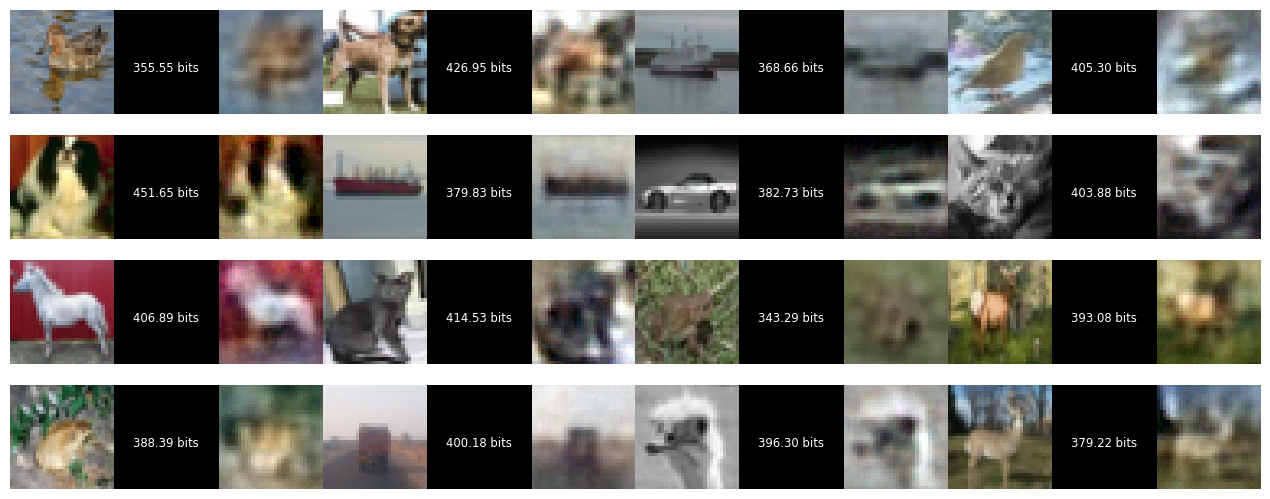

In [21]:
(originals, _), = validation_dataset.batch(16).skip(3).take(1)
strings, entropies = compressor(originals)

print(f"String representation of first compressed image (in hexadecimal): 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")

reconstructions = decompressor(strings)
display_images(originals, strings, entropies, reconstructions)


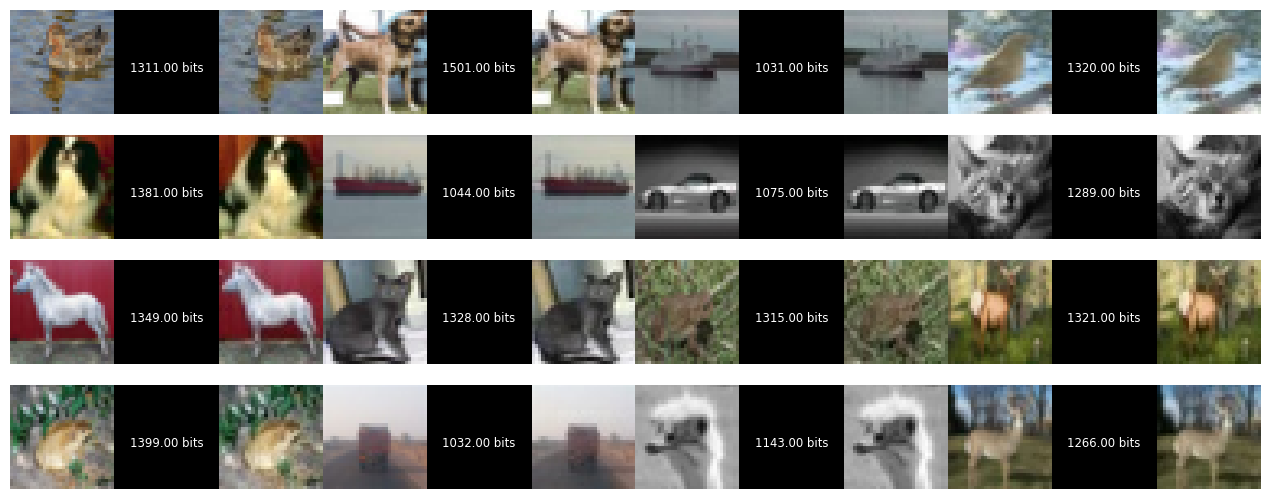

In [22]:
# Compare with JPEG

(originals, _), = validation_dataset.batch(16).skip(3).take(1)

reconstructions = []
entropies = []
for i in originals:
  j = tf.image.encode_jpeg(i)
  k = tf.image.decode_jpeg(j)
  reconstructions.append(k)
  length_j = tf.strings.length(j)
  entropies.append(length_j)

display_images(originals, strings, entropies, reconstructions)